<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регессия" data-toc-modified-id="Линейная-регессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Линейная регессия</a></span></li><li><span><a href="#Градиентный-бустинг-catboost" data-toc-modified-id="Градиентный-бустинг-catboost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Градиентный бустинг catboost</a></span></li><li><span><a href="#LightGBM-для-регрессии" data-toc-modified-id="LightGBM-для-регрессии-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM для регрессии</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом создаёт приложение для привлечения новых клиентов. В нём можно будет быстро узнать стоимость своего автомобиля.

У нас есть исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState

import time

from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import display

In [157]:
df = pd.read_csv('/datasets/autos.csv')

In [158]:
def describe_df (df):
  display(df.head(5))
  print()
  print('Проверим наличие явных дубликатов: ')
  print('Явных дубликатов: ', df.duplicated().sum())
  print()
  print('Посмотрим, какое количество пропусков в таблице: ')
  print(df.isna().sum())
  print()
  print('Выведем информацию о типах данных: ')
  print()  
  print(df.dtypes)
  print('Количество строк в таблице: ', len(df))

In [159]:
describe_df (df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Проверим наличие явных дубликатов: 
Явных дубликатов:  4

Посмотрим, какое количество пропусков в таблице: 
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Выведем информацию о типах данных: 

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode      

Признаки: 
- DateCrawled - дата скачивания анкеты из базы
- VehicleType - тип кузова автомобиля
- RegistrationYear - год регистрации автомобиля
- Gearbox - тип коробки передач
- Power - мощность автомобиля
- Model - модель автомобиля
- Kilometer - пробег
- RegistrationMonth - месяц регистрации автомобиля
- FuelType - тип топлива
- Brand - марка автомобиля
- NotRepaired - не отремонтирован
- DateCreated - дата создания анкеты
- NumberOfPictures - количество фотографий в базе
- PostalCode - код места, где происходит продажа автомобиля
- LastSeen - последний просмотр

Целевой признак: 
- Price - цена автомобиля

В таблице есть пропуски, явные дубликаты. Дубликаты удалим. Убирать выбросы в данных некорректно, потому что в последствии модели не будут знать, что делать со странными выбросами в рабочих данных.

Пропуски заполним.

Типы столбцов выглядят адекватно.

Удалим столбцы с временем  и кодом места, где происходит продажа автомобиля.

In [160]:
df = df.drop_duplicates()

In [161]:
df.duplicated().sum()

0

Перед удалением признака 'DateCrawled', посмотрим на его значения, потому что по дате скачивания анкеты из базы можно судить о годе регистрации автомобиля.

In [163]:
df['DateCrawled'].value_counts()

2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-22 10:42:10    5
2016-03-07 17:36:19    5
                      ..
2016-03-21 19:58:52    1
2016-03-28 14:58:17    1
2016-04-04 13:59:43    1
2016-03-28 17:52:14    1
2016-04-01 17:38:41    1
Name: DateCrawled, Length: 271174, dtype: int64

In [164]:
df['DateCrawled'].max()

'2016-04-07 14:36:58'

Самая последняя дата в данных это дата из 2016го года. Получается, автомобилей года выпуска 2017-2022 в базе быть не может.

In [165]:
df = df.drop(['DateCrawled','DateCreated','PostalCode','LastSeen'],axis=1)

**Обработаем пропуски:**

Признак `Model`

В данном столбце нет возможности корректнозаполнить пропуски. удалим строки с пропусками.

In [166]:
df = df.loc[~df['Model'].isna()]

Признаки `VehicleType`, `Gearbox`, `FuelType`

Данные параметры c большой вероятностью одинаковы в одинаковых моделях автомобилей. Заполним пропуски в данных признаках наиболее частым значением той же модели.

In [167]:
df.loc[df['VehicleType'].isna()].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0
16,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,0
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,0
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,0
31,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,0


Заполним пропуски согласно марке автомобиля

In [168]:
df['VehicleType'] = df['VehicleType'].fillna(df.groupby('Model')['VehicleType']
                                             .transform(lambda x: x.value_counts().idxmax())
                                             )

In [169]:
df.loc[df['Gearbox'].isna()].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,0
16,300,small,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,0
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,0
37,1500,bus,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,0
40,0,small,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,0


Заполним пропуски согласно марке автомобиля

In [170]:
df['Gearbox'] = df['Gearbox'].fillna(df.groupby('Model')['Gearbox']
                                             .transform(lambda x: x.value_counts().idxmax())
                                             )

In [171]:
df.loc[df['FuelType'].isna()].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,0
13,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,0
26,5555,sedan,2017,manual,125,c4,125000,4,NaN,citroen,no,0
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,0
41,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,0


Заполним пропуски согласно марке автомобиля

In [172]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['Gearbox']
                                             .transform(lambda x: x.value_counts().idxmax())
                                             )

Признак `NotRepaired` заменим на "no info".

In [173]:
df['NotRepaired'] = df['NotRepaired'].fillna('no info')

Теперь в таблице нет пропусков!

In [174]:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
NumberOfPictures     0
dtype: int64

Признак `Price`

array([[<AxesSubplot:title={'center':'Price'}>]], dtype=object)

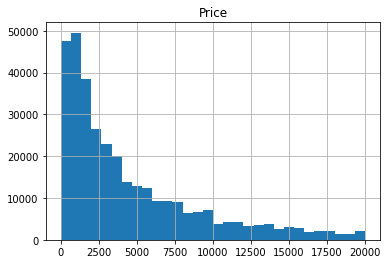

In [175]:
df.hist(column='Price', bins=30)  

In [176]:
df.loc[df['Price'] == 0].count()['Price']

8588

В таблице присутствуют девять тысяч строк с ценой авотмобиля равной нулю. Такие данные можно считать выбросом, возможно пользователи не указали цену при отправки объявления в базу. Удалим эти строки из таблицы.

In [177]:
df = df.loc[df['Price'] > 0]

В машины стоимостью меньше 400 евро тоже не верится, удалим такие строки

In [178]:
df.loc[df['Price'] < 400].count()['Price']

17010

Ещё 17 тысяч строк с подозрительной ценой.

In [179]:
df = df.loc[df['Price'] > 400]

Признак `Power`

array([[<AxesSubplot:title={'center':'Power'}>]], dtype=object)

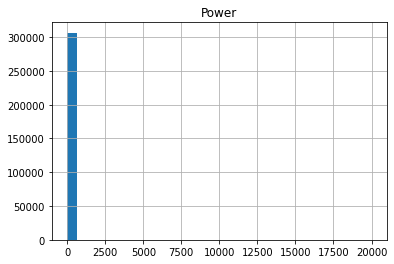

In [180]:
df.hist(column='Power', bins=30) 

Скорее всего в данных нет автомобилей с мощностью более 600 л.с. 
Удалим выбросы. Также удалим строки, где мощность равна нулю.

In [181]:
df = df.loc[df['Power'] < 600]

In [182]:
df = df.loc[df['Power'] != 0]

array([[<AxesSubplot:title={'center':'Power'}>]], dtype=object)

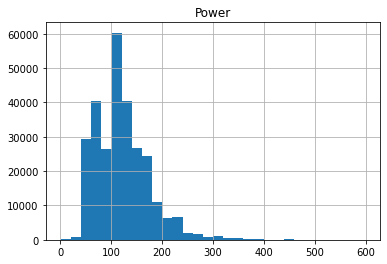

In [183]:
df.hist(column='Power', bins=30) 

Количество строк в таблице после предобработки:

In [184]:
len(df)

280853

Признак `RegistrationYear`

array([[<AxesSubplot:title={'center':'RegistrationYear'}>]], dtype=object)

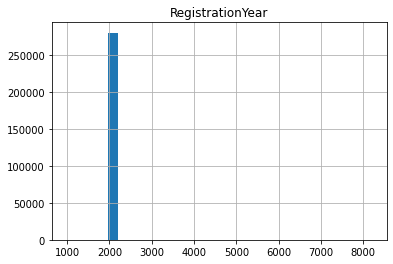

In [185]:
df.hist(column='RegistrationYear', bins=30) 

Гистограмма выгляди так, как будто у нас есть выбросы как за 2016й год, так и выбросы около нуля. Вряд ли в базе есть подержанные автомобили с годом выпуска менее 1950го года. Также в базе не может быть автомобилей с годом выпуска позднее 2016го.

Удалим выбросы:

In [186]:
df = df.loc[df['RegistrationYear'] < 2017]

In [187]:
df = df.loc[df['RegistrationYear'] > 1950]

array([[<AxesSubplot:title={'center':'RegistrationYear'}>]], dtype=object)

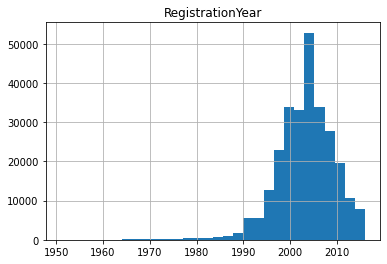

In [188]:
df.hist(column='RegistrationYear', bins=30) 

## Обучение моделей

### Линейная регессия

Чтобы обучить модель линейной регрессии необходимо закодировать категориальные переменные. 
Воспользуемся прямым кодированием One-Hot Encoding.

Разобьём данные на категориальные и числовые:

In [189]:
columns = df.columns

In [190]:
columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'NumberOfPictures'],
      dtype='object')

In [191]:
df[columns].dtypes

Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
NumberOfPictures      int64
dtype: object

Разделим столбцы на категориальные и числовые признаки

In [192]:
cols_num = df[columns].select_dtypes(include='int64').columns

In [193]:
cols_cat = df[columns].select_dtypes(exclude='int64').columns

In [194]:
cols_num

Index(['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'NumberOfPictures'],
      dtype='object')

In [195]:
cols_cat

Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], dtype='object')

In [196]:
data_ohe = pd.get_dummies(df[columns], drop_first=True)

In [197]:
data_ohe.head(5)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no info,NotRepaired_yes
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,7,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,10,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,8,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Теперь необходимо разделить данные на выборки.

In [198]:
def features_target_split (df):
  """
  input:        df - датафрейм, который необходимо разделить

  output:       features_train - тренировочные признаки
                features_val - валидационные  признаки
                features_test - тестовый признак

                target_train - тренировочный целевой признак
                target_val - валидационный целевой признак
                target_test - тестовый целевой признак 

  description:  функция разбивает датафрекйм сначала на признаки и целевой признак, 
                потом делит выборки на тренировочные, валидационные и тестовые.
                Выводит на экран размерность выборок.
  """
  features = df.drop(['Price'], axis=1)
  target = df['Price']

  features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                              test_size=0.4,random_state=42)
  features_val, features_test, target_val, target_test = train_test_split(features_test, target_test, 
                                                                          test_size=0.5,random_state=42)


  print('Для проверки посмотрим на размер выборок:')
  print('features_train.shape: ', features_train.shape)
  print('features_val.shape: ', features_val.shape)
  print('features_test.shape: ', features_test.shape)
  print()
  print('target_train.shape: ', target_train.shape)
  print('target_val.shape: ', target_val.shape)
  print('target_test.shape: ', target_test.shape)

  return features_train, features_val, features_test, target_train, target_val, target_test 

In [199]:
lin_features_train, lin_features_val, lin_features_test, lin_target_train, lin_target_val, lin_target_test = features_target_split (data_ohe)

Для проверки посмотрим на размер выборок:
features_train.shape:  (163246, 309)
features_val.shape:  (54415, 309)
features_test.shape:  (54416, 309)

target_train.shape:  (163246,)
target_val.shape:  (54415,)
target_test.shape:  (54416,)


Проведём масштабирование признаков  с помощью метода StandardScaler библиотеки sklearn. Будем масштабировать только количественные признаки:

In [200]:
cols_num

Index(['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'NumberOfPictures'],
      dtype='object')

Но только без атрибута цена.

In [201]:
cols_num_X = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'NumberOfPictures']

In [202]:
ss = StandardScaler()
ss.fit(lin_features_train[cols_num_X])

StandardScaler()

In [203]:
lin_features_train[cols_num_X] = ss.transform(lin_features_train[cols_num_X])
lin_features_val[cols_num_X] = ss.transform(lin_features_val[cols_num_X])
lin_features_test[cols_num_X] =ss.transform(lin_features_test[cols_num_X])

In [204]:
lin_features_train.head(5)

,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no info,NotRepaired_yes
320818,-0.503275,0.043709,0.601779,-0.307996,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155167,-0.183600,-1.360507,-0.080246,1.105404,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
141872,-0.183600,0.605395,0.601779,-1.156036,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80197,-0.183600,0.511780,-0.080246,-0.873356,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
298412,-0.503275,-1.079664,-1.580700,-1.438716,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Значения больше и меньше единицы объясняются тем, что СКО=1, но значения могут выходить за единицу.

In [205]:
lin_features_train['Power'].describe()

count    1.632460e+05
mean     7.965238e-17
std      1.000003e+00
min     -2.277928e+00
25%     -7.613749e-01
50%     -1.247973e-01
75%      5.117804e-01
max      8.637507e+00
Name: Power, dtype: float64

Создадим и обучим модель линейной регрессии.


In [206]:
model_l = LinearRegression()

In [207]:
%%time
start_time = time.time()
model_l.fit(lin_features_train, lin_target_train) 
learn_lin_time = (time.time() - start_time)

CPU times: user 14.9 s, sys: 7.39 s, total: 22.3 s
Wall time: 22.3 s


На тестовой выборке сделаем предсказание и посчитаем rmse для данной модели.

In [208]:
%%time
start_time = time.time()

lin_pred_test = model_l.predict(lin_features_test) 

print("--- %s seconds ---" % (time.time() - start_time))
pred_lin_time = (time.time() - start_time)

--- 0.19600677490234375 seconds ---
CPU times: user 65.1 ms, sys: 118 ms, total: 183 ms
Wall time: 198 ms


In [209]:
lin_rmse = mean_squared_error(lin_target_test, lin_pred_test)**(1/2)
lin_rmse

2562.315894338567

### Градиентный бустинг catboost

Разделим данные на тренировочную,валидационную и тестовую выборки. Оценим размер получившихся выборок.

In [210]:
train, test = train_test_split(df,test_size=0.4,random_state=42)

In [211]:
val, test = train_test_split(test,test_size=0.5,random_state=42)

In [212]:
train.shape

(163246, 12)

In [213]:
val.shape

(54415, 12)

In [214]:
test.shape

(54416, 12)

In [215]:
train.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'NumberOfPictures'],
      dtype='object')

Выделим признаки для обучения и целевой признак. Также укажем все столбцы, в которых записаны категориальные значения.

In [216]:
X = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'NumberOfPictures']

y = ['Price']

cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [217]:
params = {'cat_features':cat_features,
          'learning_rate': 0.5,
          'random_state':42,
          'iterations':1000,
          'verbose': 100}

In [218]:
model = CatBoostRegressor(**params)

In [219]:
%%time
start_time = time.time()
model.fit(train[X],train[y],eval_set=(val[X],val[y]))
learn_catb_time = (time.time() - start_time)

0:	learn: 3247.2845417	test: 3218.9524899	best: 3218.9524899 (0)	total: 288ms	remaining: 4m 48s
100:	learn: 1577.9402929	test: 1602.3989782	best: 1602.3989782 (100)	total: 18.1s	remaining: 2m 41s
200:	learn: 1509.1275550	test: 1568.8571575	best: 1568.8571575 (200)	total: 35.4s	remaining: 2m 20s
300:	learn: 1467.1312624	test: 1551.6596565	best: 1551.6596565 (300)	total: 52.9s	remaining: 2m 2s
400:	learn: 1436.3961380	test: 1541.5366691	best: 1541.5366691 (400)	total: 1m 10s	remaining: 1m 45s
500:	learn: 1413.0518458	test: 1534.4045662	best: 1534.3619227 (497)	total: 1m 28s	remaining: 1m 28s
600:	learn: 1392.9996280	test: 1529.7252767	best: 1529.6341675 (597)	total: 1m 44s	remaining: 1m 9s
700:	learn: 1375.7341766	test: 1527.1531908	best: 1527.0076176 (669)	total: 2m	remaining: 51.6s
800:	learn: 1359.9717355	test: 1525.8788548	best: 1525.7064607 (788)	total: 2m 17s	remaining: 34.2s
900:	learn: 1346.9525634	test: 1524.1713474	best: 1523.9436525 (880)	total: 2m 33s	remaining: 16.9s
999:	le

In [220]:
pred_valid = model.predict(val[X]) 

In [221]:
mean_squared_error(val[y], pred_valid)**(1/2)

1521.2914791897733

In [222]:
%%time
start_time = time.time()

pred_test = model.predict(test[X]) 
pred_catb_time = (time.time() - start_time)

CPU times: user 614 ms, sys: 3.13 ms, total: 617 ms
Wall time: 618 ms


In [223]:
catb_rmse = mean_squared_error(test[y], pred_test)**(1/2)
catb_rmse

1546.139398593443

###  LightGBM для регрессии

Модель LightGBM может работать на закодированных данных для линейной регрессии, а может работать на незакодированных данных, но необходимо поменять тип столбца с с object на category. Обучим модель на данных для линейной регрессии.


Создадим и обучим модель LightGBM. Чтобы подобрать оптимальные параметры для модели воспользуемся GridSearchCV.

In [224]:
%%time
param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [15, 20, 30, 35],
              'num_leaves' :[20,40,60],
              'n_estimators':[40,50,60]             
             }

gbm = lgb.LGBMRegressor(objective='regression')

# инициализируем GridSearchCV
grid_search = GridSearchCV(estimator = gbm, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )
grid_search.fit(lin_features_train, lin_target_train)

CPU times: user 30min 52s, sys: 1min 45s, total: 32min 37s
Wall time: 32min 58s


GridSearchCV(cv=3, estimator=LGBMRegressor(objective='regression'), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7],
                         'max_depth': [15, 20, 30, 35],
                         'n_estimators': [40, 50, 60],
                         'num_leaves': [20, 40, 60]},
             scoring='neg_mean_squared_error')

In [225]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 30, 'n_estimators': 60, 'num_leaves': 60}

In [226]:
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=60,learning_rate=0.3, n_estimators=60, max_depth=30)

In [227]:
%%time
start_time = time.time()

gbm.fit(lin_features_train, lin_target_train)
learn_gbm_time = (time.time() - start_time)

CPU times: user 4.46 s, sys: 269 ms, total: 4.73 s
Wall time: 4.77 s


In [228]:
pred_valid_gbm = gbm.predict(lin_features_val) 

In [229]:
mean_squared_error(lin_target_val, pred_valid_gbm)**(1/2)

1549.1219660967442

In [230]:
%%time
start_time = time.time()

pred_test_gbm = gbm.predict(lin_features_test) 
pred_gbm_time = (time.time() - start_time)

CPU times: user 430 ms, sys: 84.3 ms, total: 515 ms
Wall time: 502 ms


In [231]:
gbm_rmse = mean_squared_error(lin_target_test, pred_test_gbm)**(1/2)
gbm_rmse

1577.4834900435205

## Анализ моделей

Выведем в таблицу данные: для каждой модели втремя обучения на тренировочной выборке, время предсказания на тестовой выборке, RMSE модели для тестовой выборки.

In [232]:
pd.DataFrame({
    'Model'      :['learn_time','pred_time', 'rmse'],
    'lin_reg'    : [learn_lin_time,pred_lin_time, lin_rmse],
    'Catboost' : [learn_catb_time,pred_catb_time, catb_rmse],
    'Light_GBM'    : [learn_gbm_time,pred_gbm_time, gbm_rmse]
})

,Model,lin_reg,Catboost,Light_GBM
0,learn_time,22.274529,173.275877,4.773405
1,pred_time,0.198409,0.618203,0.502139
2,rmse,2562.315894,1546.139399,1577.483490


**На разных платформах таблица выглядит по-разному!**

Минимальная rmse оказалась у модели Catboost, однако данная модель сильно проигрывает в скорости обучения и немного отстаёт в скорости предсказания.

Быстрее всех учится модель Light GBM, но время предсказания у неё не самое быстрое, как и rmse не самый низкий.

Считаем оптимальной модель Light GBM, у неё близкий к лидеру параметр rmse, а время обучения и предсказания сильно короче.


## Вывод

В ходе работы было выполнено:

- Загружены данные и проведена их предобработка.
- Обучено несколько моделей.
- Выполнено сравнение моделей.
- Выбрана лучшая модель по результатам метрики RMSE, времени обучения и предсказания.

Считаем оптимальной модель Light GBM, у неё близкий к лидеру параметр rmse, а время обучения и предсказания сильно короче.